# Radon transforms

The notebook shows how we can reimplement M. Sacchi Radon_Py (https://github.com/msacchi/Radon_Py) example in just few lines of PyLops code and with an astonishing 450X faster computations.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pylops

In [2]:
def wigb(d, dt, h, xcur, ax, color='k'):
    """Plot wiggle seismic plot (python version of Xin-gong Li faumous wigb.m)
    """

    nt, nx = np.shape(d)
    dmax = np.max(d)
    d = d / dmax
    t = np.linspace(0, (nt-1)*dt, nt)
    tmax = np.amax(t)
    hmin = np.amin(h)
    hmax = np.amax(h)
    c = xcur * np.mean(np.diff(h))

    ax.axis([hmin-2*c, hmax+2*c, tmax, 0.])
    d[-1,:] = 0
    d[0,:] = 0
    for k in range(nx):
        s = d[:,k] * c
        ax.plot(s+h[k], t, color, lw=1)
        b = h[k] + s.clip(min=0) 
        ax.fill(b,t,color)

## Data creation

In [3]:
Np = 55  
Nt = 200
Nh = 25
dt = 4./1000.
dh = 20. 

p = np.linspace(-0.1,.2,Np)
h = np.linspace(0,(Nh-1)*dh,Nh)
t = np.arange(Nt) * dt

d = np.zeros((Nt,Nh))
m = np.zeros((Nt,Np))

f0 = 14
wavelet = pylops.utils.wavelets.ricker(np.arange(40)*dt,f0)[0]

Nw = len(wavelet)
href = h[Nh-1]

# Create Radon model
m[40:40+Nw,20]=wavelet
m[90:90+Nw,24]=-wavelet
m[95:95+Nw,14]=-wavelet
m[15:15+Nw,4]=wavelet
m[75:75+Nw,12]=-wavelet

In [4]:
h1 = h/href
dh1 = h1[1] - h1[0]

Sop = pylops.signalprocessing.Radon2D(t, h1, p*dh1, centeredh=False, 
                                      kind='parabolic', interp=False, engine='numba')

# Data
d1 = Sop @ m.T.ravel()
d1 = d1.reshape(Nh, Nt).T

# LSQR model
minv1 = Sop.div(d1.T.ravel(), niter=10)
minv1 = minv1.reshape(Np, Nt).T

dp1 = Sop @ minv1.T.ravel()
dp1 = dp1.reshape(Nh, Nt).T

# FISTA model
minv2 = pylops.optimization.sparsity.fista(Sop, d1.T.ravel(), eps=1e-1, niter=200)[0]
minv2 = minv2.reshape(Np, Nt).T

dp2 = Sop @ minv2.T.ravel()
dp2 = dp2.reshape(Nh, Nt).T

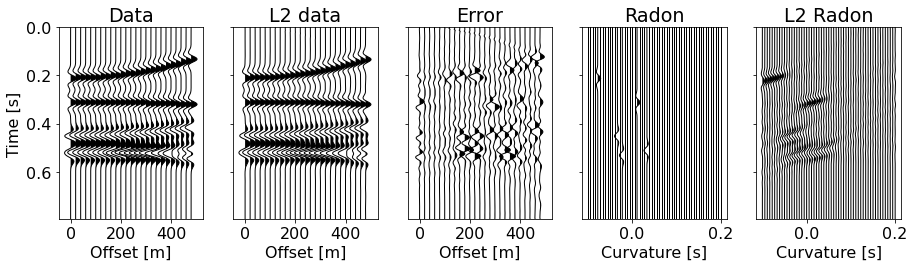

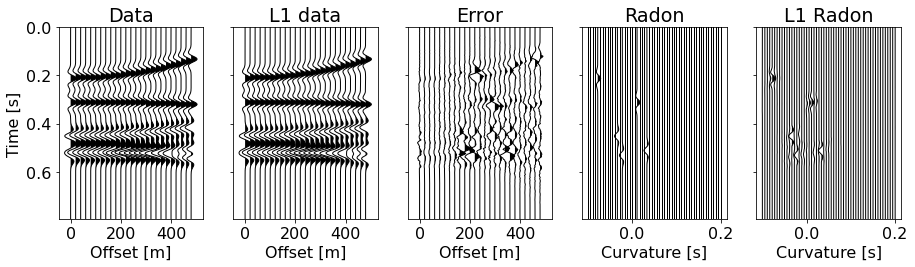

In [5]:
xcur = 1.2

# L2 Radon
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(13, 4))
           
wigb(d1,dt,h,xcur,axs[0],'k')
axs[0].set_title('Data')
axs[0].set_xlabel('Offset [m]')
axs[0].set_ylabel('Time [s]')

wigb(dp1,dt,h,xcur,axs[1],'k')
axs[1].set_title('L2 data')
axs[1].set_xlabel('Offset [m]')

wigb(d1-dp1,dt,h,xcur,axs[2],'k')
axs[2].set_title('Error')
axs[2].set_xlabel('Offset [m]')

wigb(m,dt,p,xcur,axs[3],'k')
axs[3].set_title('Radon')
axs[3].set_xlabel('Curvature [s]')

wigb(minv1,dt,p,xcur,axs[4],'k')
axs[4].set_title('L2 Radon')
axs[4].set_xlabel('Curvature [s]')

fig.tight_layout()

# L1 Radon
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(13, 4))
           
wigb(d1,dt,h,xcur,axs[0],'k')
axs[0].set_title('Data')
axs[0].set_xlabel('Offset [m]')
axs[0].set_ylabel('Time [s]')

wigb(dp2,dt,h,xcur,axs[1],'k')
axs[1].set_title('L1 data')
axs[1].set_xlabel('Offset [m]')

wigb(d1-dp2,dt,h,xcur,axs[2],'k')
axs[2].set_title('Error')
axs[2].set_xlabel('Offset [m]')

wigb(m,dt,p,xcur,axs[3],'k')
axs[3].set_title('Radon')
axs[3].set_xlabel('Curvature [s]')

wigb(minv2,dt,p,xcur,axs[4],'k')
axs[4].set_title('L1 Radon')
axs[4].set_xlabel('Curvature [s]')

fig.tight_layout()

Finally, let's do something more interesting. We can mute the negative side of the Radon transform and see what happens to the data

In [10]:
# Mask Radon panels
minv1[:, :np.where(p>0)[0][0]-1] = 0
minv2[:, :np.where(p>0)[0][0]-1] = 0

dp1_filt = Sop @ minv1.T.ravel()
dp1_filt = dp1_filt.reshape(Nh, Nt).T

dp2_filt = Sop @ minv2.T.ravel()
dp2_filt = dp2_filt.reshape(Nh, Nt).T

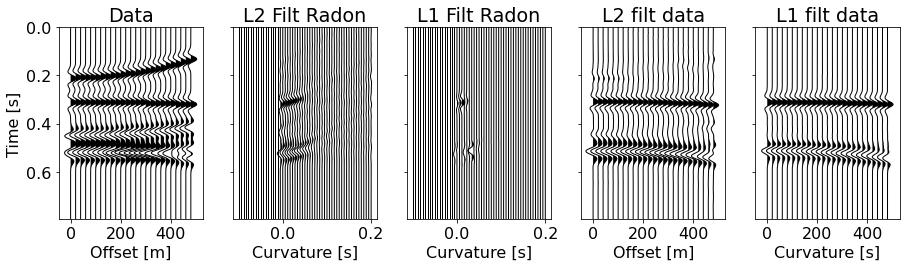

In [13]:
# L1 Radon
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(13, 4))
           
wigb(d1,dt,h,xcur,axs[0],'k')
axs[0].set_title('Data')
axs[0].set_xlabel('Offset [m]')
axs[0].set_ylabel('Time [s]')

wigb(minv1,dt,p,xcur,axs[1],'k')
axs[1].set_title('L2 Filt Radon')
axs[1].set_xlabel('Curvature [s]')

wigb(minv2,dt,p,xcur,axs[2],'k')
axs[2].set_title('L1 Filt Radon')
axs[2].set_xlabel('Curvature [s]')

wigb(dp1_filt,dt,h,xcur,axs[3],'k')
axs[3].set_title('L2 filt data')
axs[3].set_xlabel('Offset [m]')

wigb(dp2_filt,dt,h,xcur,axs[4],'k')
axs[4].set_title('L1 filt data')
axs[4].set_xlabel('Curvature [s]')

fig.tight_layout()